# Sequencing of cardiac tissue samples to investigate somatic mosaicism in cardiac tissue

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import statistics as stats
from collections import Counter
from scipy.stats import fisher_exact, yeojohnson, wilcoxon
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, pearsonr
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import rc
import scipy
import scipy.cluster.hierarchy as sch
from statsmodels.formula.api import ols

rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

In [2]:
def plot_histogram(dataframe, column, xlab, ylab, xlim1, xlim2, b = 150):
    plt.hist(dataframe[column], bins = b)
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.xlim(xlim1, xlim2)
    plt.show()
    print("Min: " + str(min(dataframe[column])))
    print("Max: " + str(max(dataframe[column])))
    print("Median: " + str(stats.median(dataframe[column])))

## Background

- Evidence for somatic mosaicism in cardiac tissue is from Yizhak et al, 2019 who used RNA-MuTect to detect somatic mutations in healthy tissue from GTeX data https://pubmed.ncbi.nlm.nih.gov/31171663. 
- Review by Sano et al in 2019 demonstrated that expansion of mutant clones in CV tissue at VAF >2% was 518 mutations in blood vessels per 287 individuals and 256 mutations in the hearts of 138 individuals doi:10.1093/eurheartj/ehz907

## Importing Brett's dataset

Samples from RA, LA, RV, Septum, Aorta, PA, and blood from explanted hearts from individuals who underwent a heart transplant. Assayed for SNPs in CHIP assay, CV assay, CAD PRS, and AF PRS

In [3]:
! gsutil cp 'gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/CV tissue analysis/complete_concat_vcf_filtered.tsv' .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/CV tissue analysis/complete_concat_vcf_filtered.tsv...
- [1 files][ 63.4 MiB/ 63.4 MiB]                                                
Operation completed over 1 objects/63.4 MiB.                                     


In [4]:
df = pd.read_csv('complete_concat_vcf_filtered.tsv', sep='\t') #dataset of all SNP transcripts detected

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Checking counts by patient

In [5]:
# Exclude 181
df = df[df['patientID']!=181]

In [6]:
patientID_tissue_counts_df = pd.DataFrame(df.groupby(["patientID", "tissuetype"]).size())
patientID_tissue_counts_df.to_csv('patientID_tissue_counts.csv')
! gsutil cp patientID_tissue_counts.csv 'gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/CV tissue analysis/patientID_tissue_counts.csv'

Copying file://patientID_tissue_counts.csv [Content-Type=text/csv]...
/ [1 files][  2.0 KiB/  2.0 KiB]                                                
Operation completed over 1 objects/2.0 KiB.                                      


### Creating SNP names

In [7]:
df['SNP'] = df.apply(lambda row: str(row.chr)+ ':' + str(row.pos) + ":" + str(row.ref) + ">" + str(row.alt), axis=1)

In [8]:
df['ExonicFunc.refGene'].unique()

array(['nonsynonymous_SNV', 'nonframeshift_deletion', 'stopgain',
       'nonframeshift_insertion', 'frameshift_deletion',
       'frameshift_insertion', 'startloss', '.', 'synonymous_SNV',
       'stoploss'], dtype=object)

### Creating dictionaries by patient ID and by SNP

In [9]:
patientID_LVEF_dict = pd.Series(df.LVEF.values,index=df.patientID).to_dict()
patientID_CM_Type_dict = pd.Series(df.CM_Type.values,index=df.patientID).to_dict()

In [10]:
SNP_refGene_dict = pd.Series(df['Gene.refGene'].values,index=df.SNP).to_dict()
SNP_exonfunction_dict = pd.Series(df['ExonicFunc.refGene'].values,index=df.SNP).to_dict()
SNP_AF_dict = pd.Series(df.AF.values,index=df.SNP).to_dict()

In [11]:
def map_columns(dataframe, newColName, refColName, dictionary):
    dataframe[newColName] = dataframe[refColName].map(dictionary)
    return dataframe

In [12]:
unmapped_snps = {'chr5:256357:G>A': 'SDHA', 
                 'chr9:136496492:TGTG>T': 'NOTCH1', 
                 'chr22:28695852:T>C': 'CHEK2',
                 'chr5:236502:G>T': 'SDHA', 
                 'chr12:25245347:C>A': 'KRAS',
                 'chr17:7674221:G>A': 'TP53'
                }
SNP_refGene_dict_all = {}
for key, value in SNP_refGene_dict.items():
    if key in unmapped_snps.keys():
        SNP_refGene_dict_all[key] = unmapped_snps[key]
    else:
        SNP_refGene_dict_all[key] = value
df = map_columns(df, 'refGene', 'SNP', SNP_refGene_dict_all)

## QC

### Dropping SDHA d/t concerns about assay

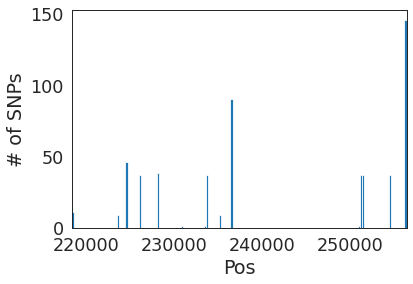

Min: 218352
Max: 256434
Median: 236563.0


In [16]:
plot_histogram(df[df['refGene']=='SDHA'], 'pos', 'Pos', '# of SNPs', 218352, 256434)

In [15]:
df = df[~df['pos'].isin(set(df[df['refGene']=='SDHA'].value_counts('pos').index[0:5]))]

### Plots for all SNPs in the dataset

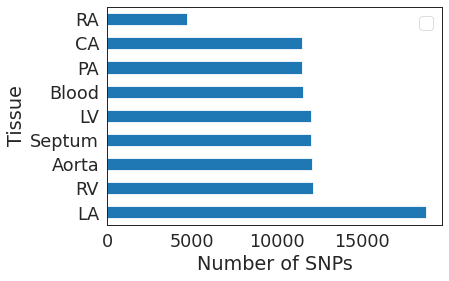

In [17]:
pd.DataFrame(pd.DataFrame(df['tissuetype'].value_counts())).plot.barh()
plt.xlabel('Number of SNPs')
plt.ylabel('Tissue')
plt.legend([])
plt.show()

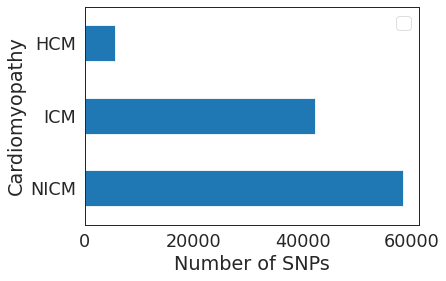

In [18]:
pd.DataFrame(pd.DataFrame(df['CM_Type'].value_counts())).plot.barh()
plt.xlabel('Number of SNPs')
plt.ylabel('Cardiomyopathy')
plt.legend([])
plt.show()

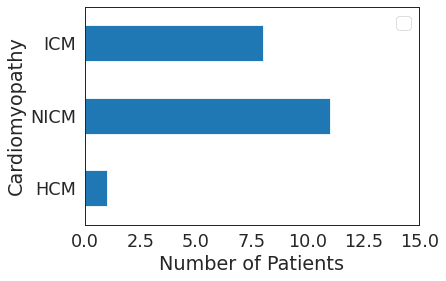

In [19]:
pd.DataFrame.from_dict(Counter(patientID_CM_Type_dict.values()), orient='index').plot.barh()
plt.xlabel('Number of Patients')
plt.ylabel('Cardiomyopathy')
plt.legend([])
plt.xlim(0,15)
plt.show()

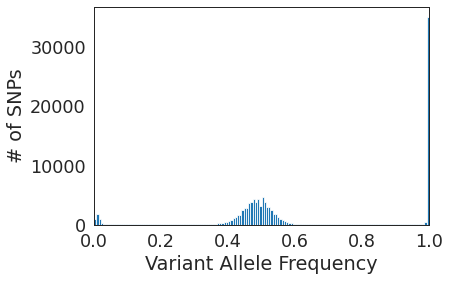

Min: 0.0
Max: 1.0
Median: 0.513


In [20]:
plot_histogram(df, 'AF', 'Variant Allele Frequency', '# of SNPs', 0, 1)

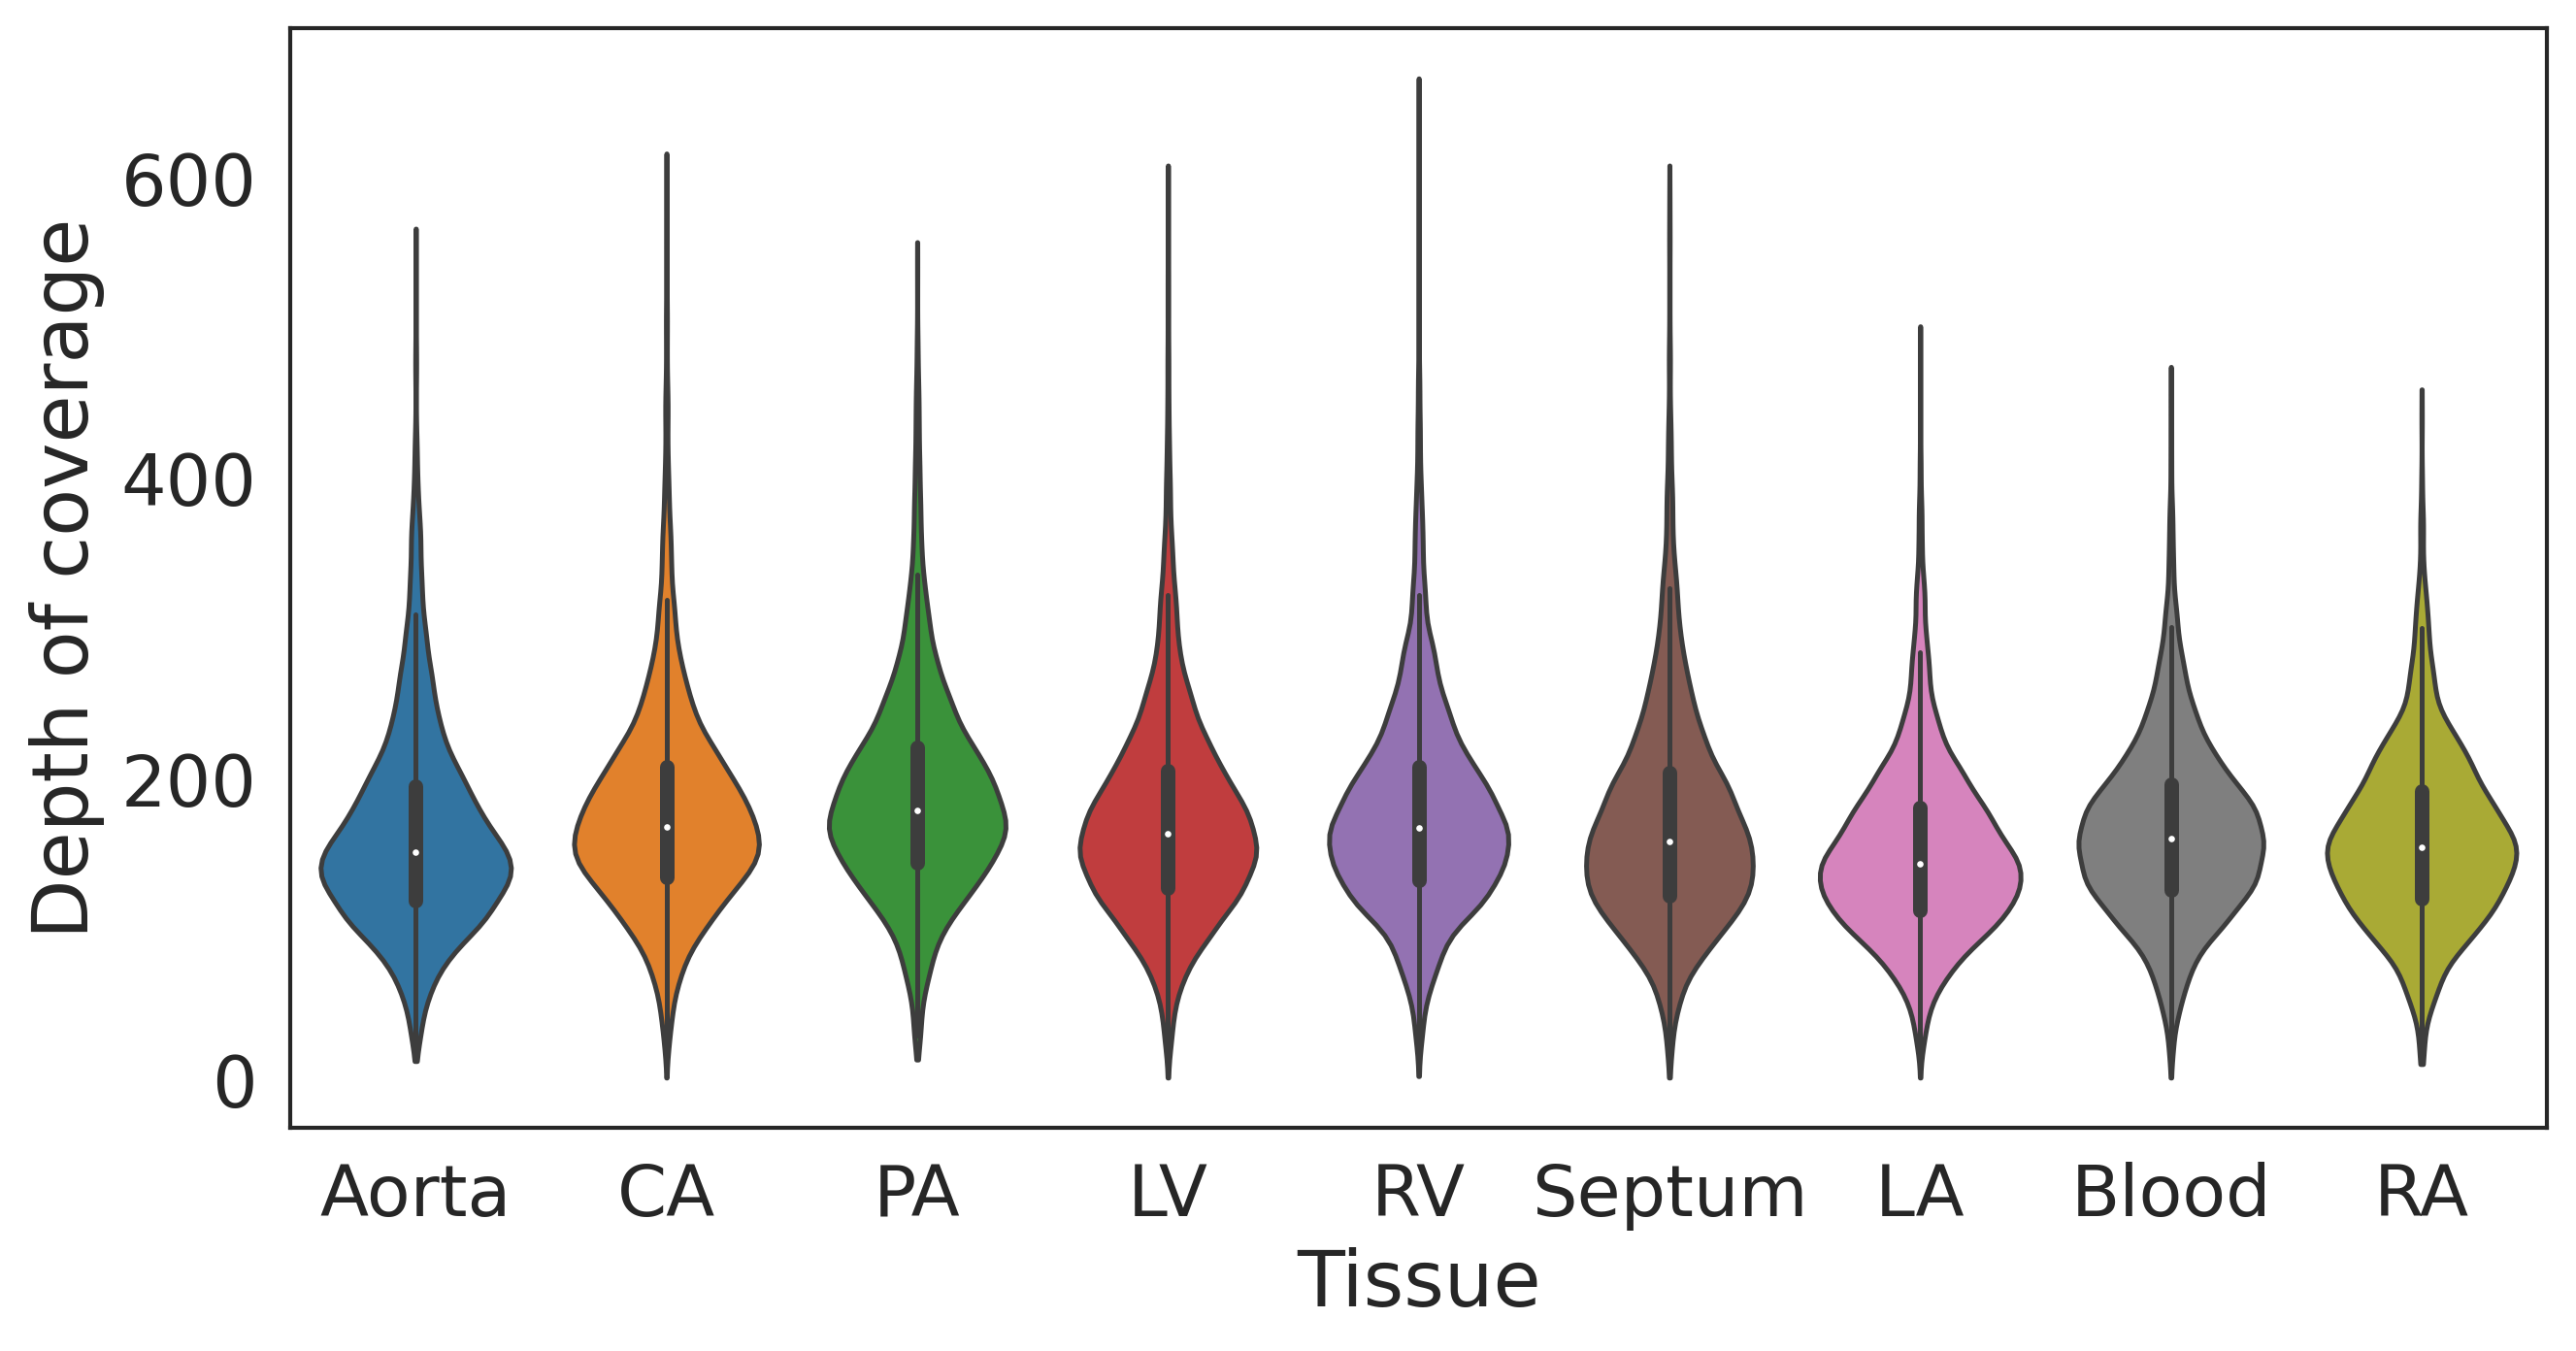

(                  sum_sq        df           F  PR(>F)
 tissuetype  1.226192e+07       8.0  366.564489     0.0
 Residual    4.444331e+08  106289.0         NaN     NaN,
               count        mean        std   min    25%    50%    75%    max
 tissuetype                                                                  
 Aorta       12102.0  163.523219  68.080850  12.0  119.0  151.0  195.0  566.0
 Blood       11557.0  164.004413  58.039991   1.0  126.0  160.0  196.0  474.0
 CA          11458.0  176.373102  66.680305   1.0  134.0  168.0  208.0  616.0
 LA          18818.0  150.764853  57.975325   1.0  112.0  143.5  181.0  501.0
 LV          12013.0  171.860068  67.313806   1.0  127.0  163.0  205.0  608.0
 PA          11463.0  187.122830  67.326817  13.0  144.0  179.0  221.0  557.0
 RA           4721.0  159.314976  57.222948  10.0  120.0  154.0  192.0  459.0
 RV          12145.0  175.545080  66.541754   2.0  132.0  167.0  208.0  666.0
 Septum      12021.0  169.399135  70.426865   1.0  

In [21]:
table = df.groupby('tissuetype').describe()['DP']
fig, ax = plt.subplots(1, 1, figsize = (10, 5), dpi=300)
ax = sns.violinplot(x = 'tissuetype', y = 'DP',
            data=df, cut=0)
ax.set(xlabel='Tissue', ylabel= 'Depth of coverage')
plt.show()
model = ols('DP ~ tissuetype', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table, table

### Filtering for mutations with sufficient depth of coverage in each tissue type

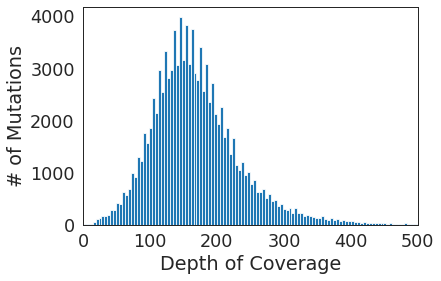

Min: 1
Max: 666
Median: 160.0


In [22]:
plot_histogram(df, 'DP', 'Depth of Coverage', '# of Mutations', 0, 500)

In [23]:
def filter_snps_by_depth(df, min_depth):
    snps_to_keep = set()
    for patientID, patientdf in df.groupby('patientID'):
        for snp, snpdf in patientdf.groupby('SNP'):
            if min(snpdf['DP'])> min_depth: 
            #since this dataset only includes variants, ensure sufficicent depth in whatever tissue it was found in
            #assumes other tissue has similar depth
                snps_to_keep.add((patientID, snp))
    return df[df[['patientID', 'SNP']].apply(tuple, axis=1).isin(snps_to_keep)]

### Determine optimal depth for filtering

In [34]:
def filter_by_VAF(df, lower, upper):
    nums = len(df[(df['AF']>lower) & (df['AF']<upper)]), len(df[(df['AF']>lower) & (df['AF']<upper) & (df['BINOM'] < 0.05)]), len(df[(df['AF']>lower) & (df['AF']<upper) & (df['BINOM'] < 0.05) & (df['ExonicFunc.refGene']!='synonymous_SNV')])
    return nums, df[(df['AF']>lower) & (df['AF']<upper) & (df['BINOM'] < 0.05) & (df['ExonicFunc.refGene']!='synonymous_SNV')]

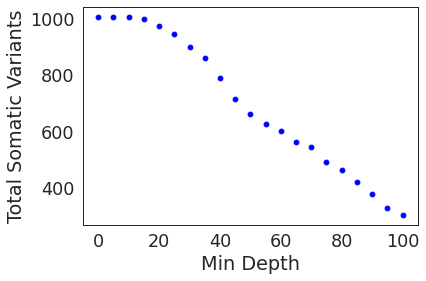

In [29]:
x = list()
y = list()
for d in np.linspace(0, 100, 21):
    x.append(d)
    y.append(filter_by_VAF(filter_snps_by_depth(df, d), 0.02, 0.35)[0][2])
plt.plot(x,y,'bo')
plt.xlabel('Min Depth')
plt.ylabel('Total Somatic Variants')
plt.show()

Selected a depth of coverage of 40

In [24]:
d = 40

In [25]:
df_depth_tissue = filter_snps_by_depth(df, d)

## Detecting mosaicism based on discordance with blood

In [26]:
def detect_uniqueSNPs_mosaicism_blood(dataframe):
    perpatient_tissue_uniqueSNP_dict = defaultdict(dict)
    for patientID, patientdf in dataframe.groupby('patientID'):
        patient_snpsbytissue = dict()
        for snp, snpdf in patientdf.groupby('SNP'):
            tissue_set = set(snpdf['tissuetype'])
            if 'Blood' not in tissue_set:
                patient_snpsbytissue[snp] = tissue_set
        perpatient_tissue_uniqueSNP_dict[patientID] = patient_snpsbytissue
    return perpatient_tissue_uniqueSNP_dict

In [27]:
def convert_uniqueSNPs_to_df_novaf(dictionary):
    patient_tissue_uniqueSNP_list = []
    for patientID, uniqueSNPbytissue in dictionary.items():
        for snp, tissues in uniqueSNPbytissue.items():
            for tissue in tissues:
                patient_tissue_uniqueSNP_list.append([patientID, tissue, snp])
    return pd.DataFrame(patient_tissue_uniqueSNP_list, columns = ['patientID', 'tissue', 'SNP'])

In [28]:
perpatient_tissue_uniqueSNP_dict_novaf = detect_uniqueSNPs_mosaicism_blood(df_depth_tissue)
patient_tissue_uniqueSNP_df_novaf = convert_uniqueSNPs_to_df_novaf(perpatient_tissue_uniqueSNP_dict_novaf)
patient_tissue_uniqueSNP_df_novaf = map_columns(patient_tissue_uniqueSNP_df_novaf, 'refGene', 'SNP', SNP_refGene_dict)
patient_tissue_uniqueSNP_df_novaf = map_columns(patient_tissue_uniqueSNP_df_novaf, 'exonicFunc', 'SNP', SNP_exonfunction_dict)
patient_tissue_uniqueSNP_df_novaf = map_columns(patient_tissue_uniqueSNP_df_novaf, 'LVEF', 'patientID', patientID_LVEF_dict)
patient_tissue_uniqueSNP_df_novaf = map_columns(patient_tissue_uniqueSNP_df_novaf, 'CM_Type', 'patientID', patientID_CM_Type_dict)
patient_tissue_uniqueSNP_df_novaf = map_columns(patient_tissue_uniqueSNP_df_novaf, 'AF', 'SNP', SNP_AF_dict)

In [30]:
patient_tissue_uniqueSNP_df_novaf = patient_tissue_uniqueSNP_df_novaf[(patient_tissue_uniqueSNP_df_novaf['exonicFunc']!='synonymous_SNV')]

In [102]:
patient_tissue_uniqueSNP_df_novaf = patient_tissue_uniqueSNP_df_novaf[patient_tissue_uniqueSNP_df_novaf['refGene']!='exonic']

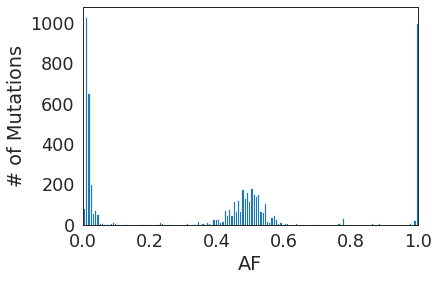

Min: 0.0
Max: 1.0
Median: 0.461


In [103]:
plot_histogram(patient_tissue_uniqueSNP_df_novaf, 'AF', 'AF', '# of Mutations', 0, 1)

### Variation in depth of coverage by tissue of origin

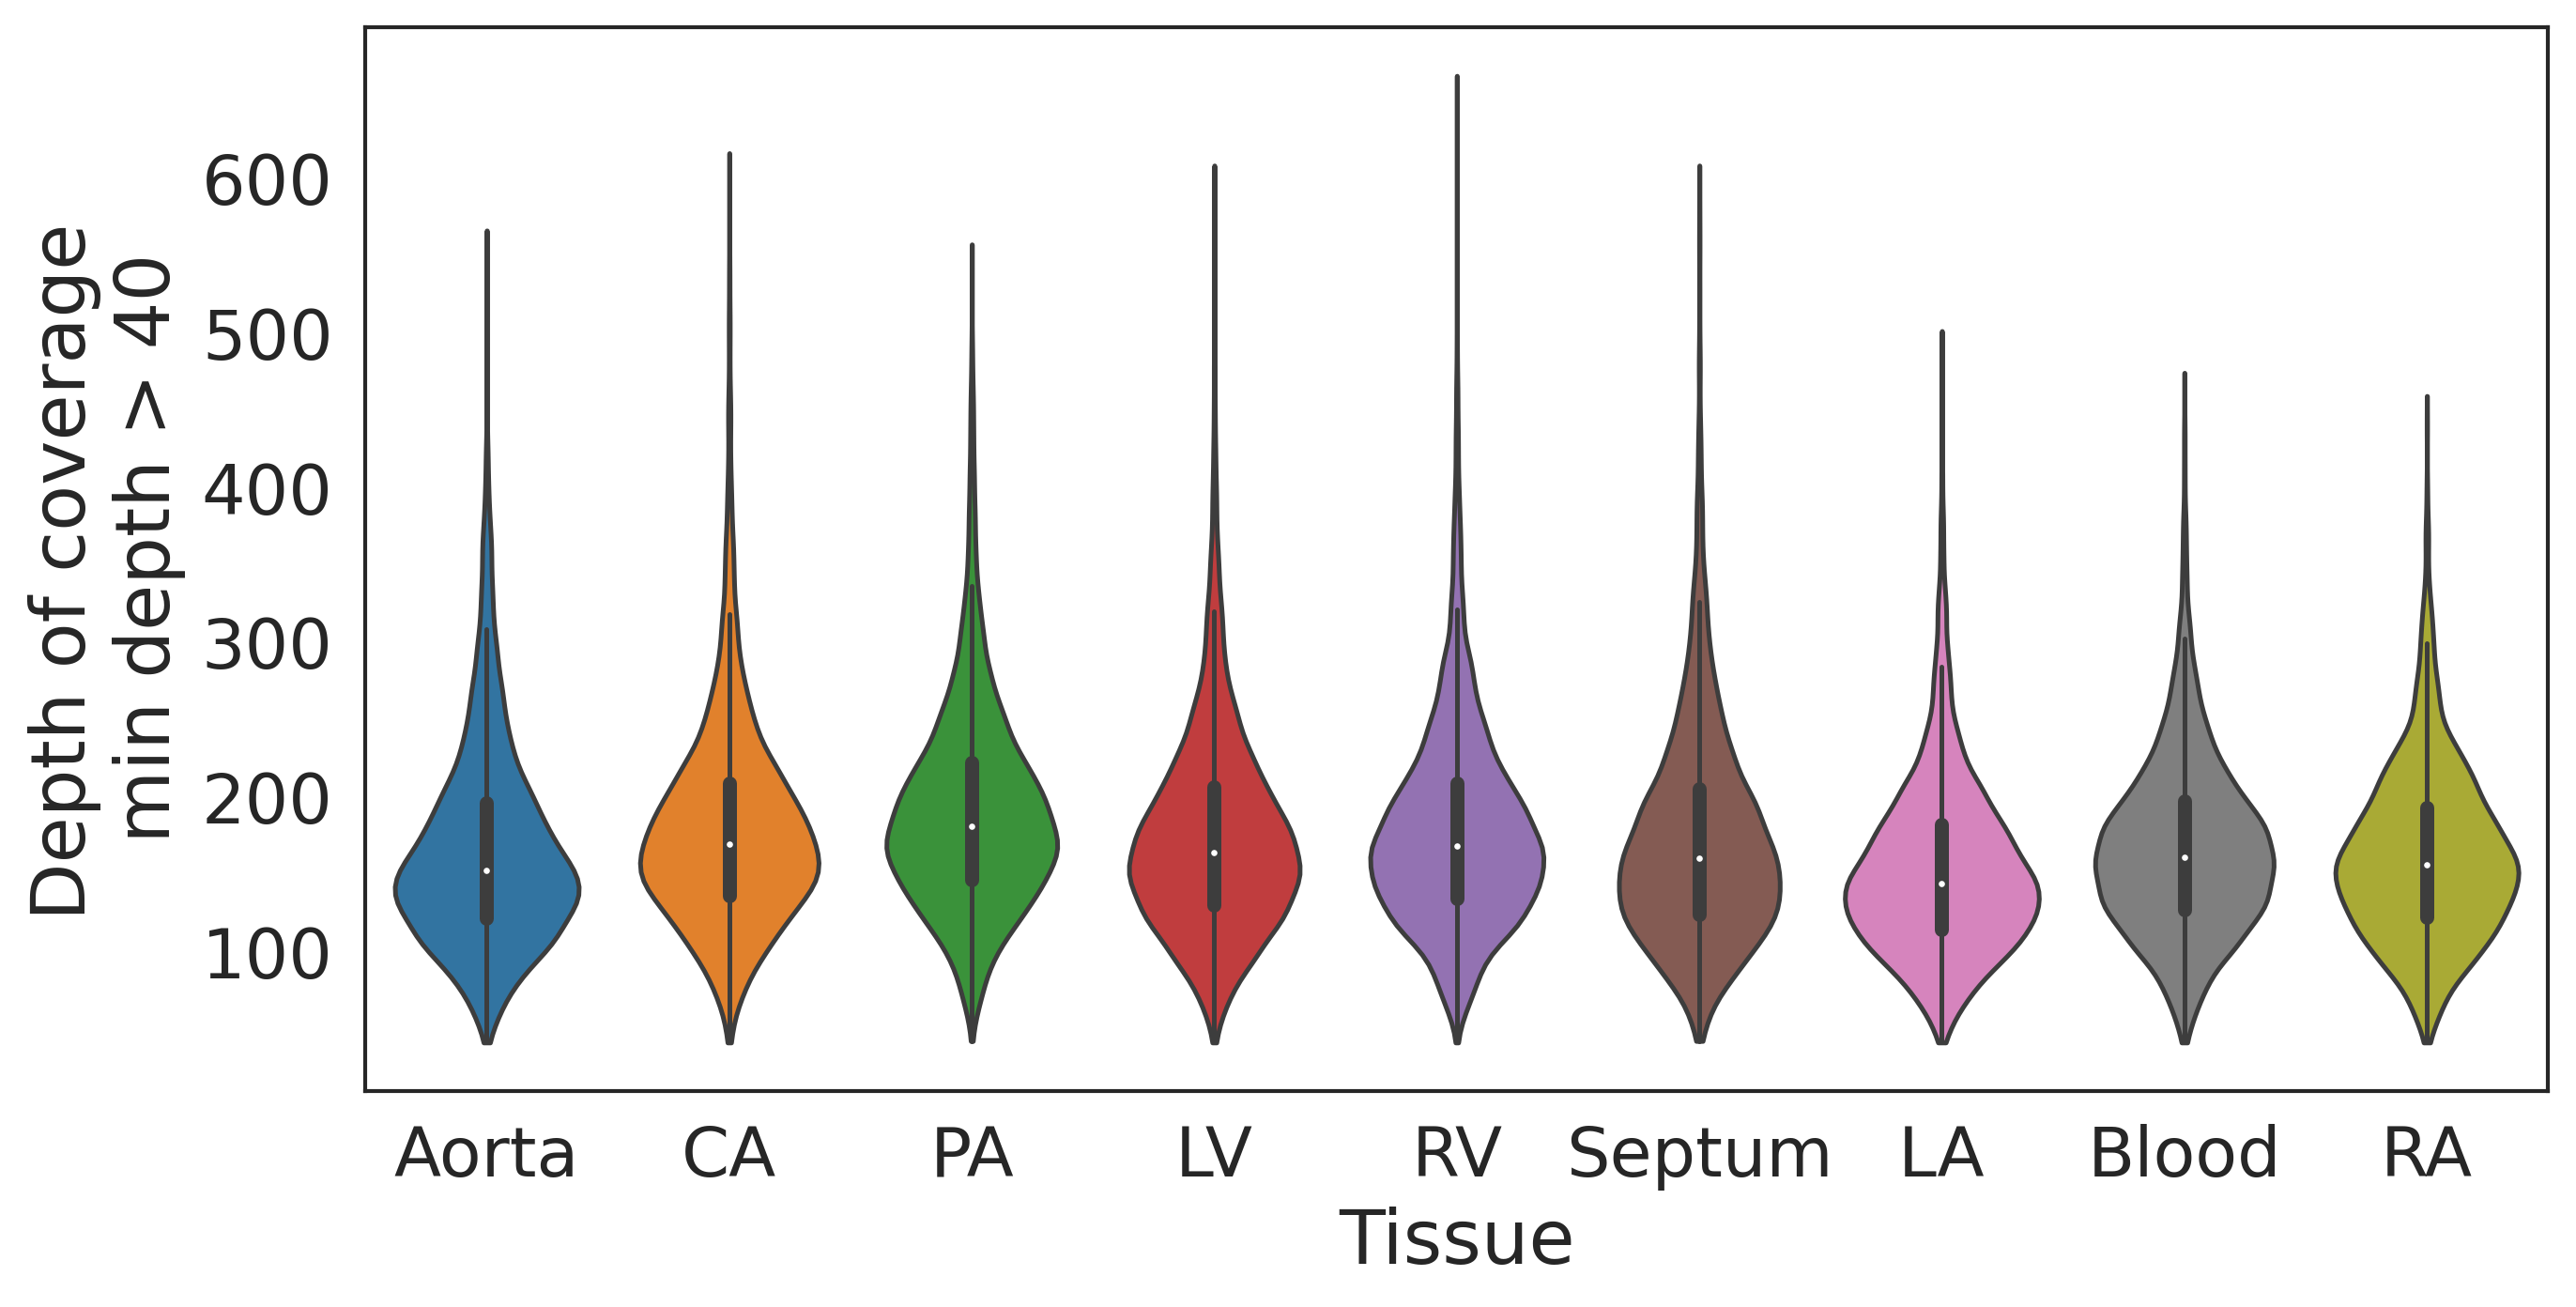

(                  sum_sq        df           F  PR(>F)
 tissuetype  1.234807e+07       8.0  387.441476     0.0
 Residual    4.163999e+08  104522.0         NaN     NaN,
               count        mean        std   min    25%    50%    75%    max
 tissuetype                                                                  
 Aorta       11891.0  165.646876  66.727171  41.0  121.0  152.0  196.0  566.0
 Blood       11372.0  165.975466  56.352491  41.0  127.0  161.0  197.0  474.0
 CA          11274.0  178.484123  65.078822  41.0  136.0  169.0  209.0  616.0
 LA          18506.0  152.624716  56.607603  41.0  114.0  144.0  182.0  501.0
 LV          11806.0  174.057937  65.745310  41.0  130.0  164.0  206.0  608.0
 PA          11271.0  189.435276  65.449025  42.0  146.0  181.0  222.0  557.0
 RA           4642.0  161.284360  55.603974  41.0  122.0  156.0  193.0  459.0
 RV          11945.0  177.713185  64.889285  41.0  134.0  168.0  209.0  666.0
 Septum      11824.0  171.500085  69.046275  42.0  

In [104]:
df_depth_tissue = filter_snps_by_depth(df, d)
table = df_depth_tissue.groupby('tissuetype').describe()['DP']
fig, ax = plt.subplots(1, 1, figsize = (10, 5), dpi=300)
ax = sns.violinplot(x = 'tissuetype', y = 'DP',
            data=df_depth_tissue, cut=0)
ax.set(xlabel='Tissue', ylabel= 'Depth of coverage \n min depth > 40')
plt.show()
model = ols('DP ~ tissuetype', data=df_depth_tissue).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table, table

### Filter for somatic nonsynonymous variants (2% < VAF < 35% and p < 0.05 on binomial test for null hypothesis of VAF = 0.5, nonsynonymous annotation) among variants with minimum depth > 40

| Criteria | n | 
| :--- | :--- |
| VAF 2%-35% | 1093 |
| VAF 2%-35% & binomial p < 0.05 | 1079 |
| VAF 2%-35% & binomial p < 0.05 & nonsynonymous| 947 |
| VAF 10%-35% | 104 |
| VAF 10%-35% & binomial p < 0.05 | 97 |
| VAF 2%-35% & binomial p < 0.05 & nonsynonymous| 87 |


In [105]:
nums, df_filtered_vaf = filter_by_VAF(filter_snps_by_depth(df, d), 0.02, 0.35)
print(nums)

(1093, 1079, 947)


### Plots for somatic variants only

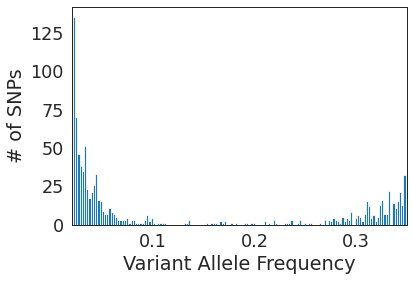

Min: 0.021
Max: 0.349
Median: 0.043


In [106]:
plot_histogram(df_filtered_vaf, 'AF', 'Variant Allele Frequency', '# of SNPs', 0.02, 0.35)

### Filter for stricter somatic nonsynonymous variants (10% < VAF < 30% and p < 0.05 on binomial tests for null hypothesis of VAF = 0, nonsynonymous annotation)

In [107]:
strict_nums, df_strict_vaf = filter_by_VAF(filter_snps_by_depth(df, d), 0.10, 0.30)
print(strict_nums)

(104, 97, 87)


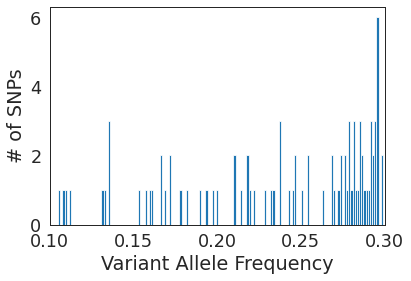

Min: 0.105
Max: 0.299
Median: 0.255


In [108]:
plot_histogram(df_strict_vaf, 'AF', 'Variant Allele Frequency', '# of SNPs', 0.10, 0.30)

### Call germline variants if VAF > 35% and in blood

In [109]:
df_germline = df_depth_tissue[(df_depth_tissue['AF']>0.35) & (df_depth_tissue['tissuetype']=='Blood')]

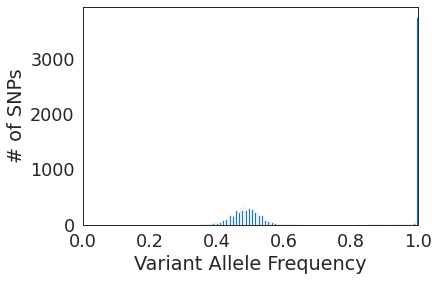

Min: 0.351
Max: 1.0
Median: 0.517


In [110]:
plot_histogram(df_germline, 'AF', 'Variant Allele Frequency', '# of SNPs', 0, 1)

In [111]:
perpatient_germline_dict = dict()
for patientID, patientdf in df_germline.groupby('patientID'):
    SNPcounts = patientdf.value_counts('SNP')
    perpatient_germline_dict[patientID] = set(SNPcounts.index)

## Detecting mosaicism compared to germline mutations in the blood using VAF

In [112]:
def convert_uniqueSNPs_to_df(dictionary):
    patient_tissue_uniqueSNP_list = []
    for patientID, uniqueSNPbytissue in dictionary.items():
        for tissue, uniqueSNPs in uniqueSNPbytissue.items():
            for SNP in uniqueSNPs:
                patient_tissue_uniqueSNP_list.append([patientID, tissue, SNP])
    return pd.DataFrame(patient_tissue_uniqueSNP_list, columns = ['patientID', 'tissue', 'SNP'])

In [113]:
def detect_uniqueSNPs_mosaicism_germline(dataframe, germline_dict):
    perpatient_tissue_uniqueSNP_dict = defaultdict(dict)
    for patientID, patientdf in dataframe.groupby('patientID'):
        patient_snpsbytissue = dict()
        for tissue, tissuedf in patientdf.groupby('tissuetype'):
            SNPcounts = tissuedf.value_counts('SNP')
            patient_snpsbytissue[tissue] = set(SNPcounts.index)
        tissue_uniqueSNP_dict = dict()
        for tissue, snpset in patient_snpsbytissue.items():
            if patientID not in germline_dict.keys():
                germline_dict[patientID] = set()
            uniqueTissueSNPs = patient_snpsbytissue[tissue] - germline_dict[patientID]
            tissue_uniqueSNP_dict[tissue]=uniqueTissueSNPs
        perpatient_tissue_uniqueSNP_dict[patientID] = tissue_uniqueSNP_dict
    return perpatient_tissue_uniqueSNP_dict

In [114]:
perpatient_tissue_uniqueSNP_dict_filtered_germline = detect_uniqueSNPs_mosaicism_germline(df_strict_vaf, perpatient_germline_dict)
patient_tissue_uniqueSNP_df_filtered_germline = convert_uniqueSNPs_to_df(perpatient_tissue_uniqueSNP_dict_filtered_germline)
patient_tissue_uniqueSNP_df_filtered_germline = map_columns(patient_tissue_uniqueSNP_df_filtered_germline, 'refGene', 'SNP', SNP_refGene_dict)
patient_tissue_uniqueSNP_df_filtered_germline = map_columns(patient_tissue_uniqueSNP_df_filtered_germline, 'exonicFunc', 'SNP', SNP_exonfunction_dict)
patient_tissue_uniqueSNP_df_filtered_germline = map_columns(patient_tissue_uniqueSNP_df_filtered_germline, 'LVEF', 'patientID', patientID_LVEF_dict)
patient_tissue_uniqueSNP_df_filtered_germline = map_columns(patient_tissue_uniqueSNP_df_filtered_germline, 'CM_Type', 'patientID', patientID_CM_Type_dict)
patient_tissue_uniqueSNP_df_filtered_germline = map_columns(patient_tissue_uniqueSNP_df_filtered_germline, 'AF', 'SNP', SNP_AF_dict)

## Comparing VAF-derived SNPs and discordance-derived SNPs

In [115]:
def barplot_uniqueSNPs(df, column, xlab, ylab):
    pd.DataFrame(df.value_counts(column), columns = ['']).plot.barh()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.legend([])
    plt.show()

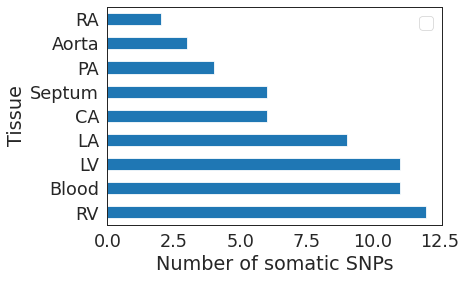

In [116]:
barplot_uniqueSNPs(patient_tissue_uniqueSNP_df_filtered_germline, 'tissue', 'Number of somatic SNPs', 'Tissue')

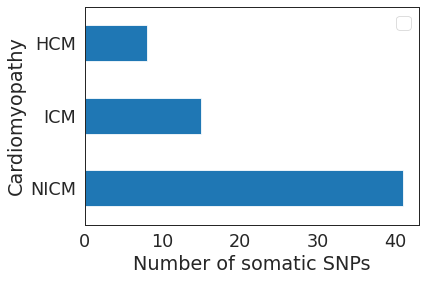

In [117]:
barplot_uniqueSNPs(patient_tissue_uniqueSNP_df_filtered_germline, 'CM_Type', 'Number of somatic SNPs', 'Cardiomyopathy')

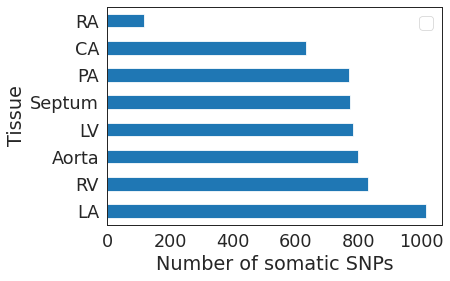

In [118]:
barplot_uniqueSNPs(patient_tissue_uniqueSNP_df_novaf, 'tissue', 'Number of somatic SNPs', 'Tissue')

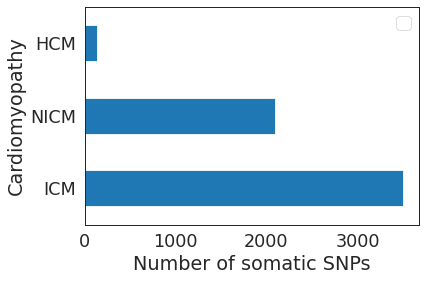

In [119]:
barplot_uniqueSNPs(patient_tissue_uniqueSNP_df_novaf, 'CM_Type', 'Number of somatic SNPs', 'Cardiomyopathy')

In [120]:
uniqueSNP_genes_novaf = set(patient_tissue_uniqueSNP_df_novaf['refGene'].unique())
uniqueSNPs_novaf = set(patient_tissue_uniqueSNP_df_novaf['SNP'].unique())

In [121]:
len(uniqueSNPs_novaf)

2420

In [122]:
uniqueSNP_genes_vaf = set(patient_tissue_uniqueSNP_df_filtered_germline['refGene'].unique())
uniqueSNPs_vaf = set(patient_tissue_uniqueSNP_df_filtered_germline['SNP'].unique())

In [123]:
len(uniqueSNPs_vaf)

29

In [233]:
len(uniqueSNPs_novaf.intersection(uniqueSNPs_vaf))

25

25/29 of the VAF derived somatic variants were in the discordance

In [181]:
patient_snp_tissuecount = dict()
cooccurring_tissues = list()
for patientID, snp_tissue_set in detect_uniqueSNPs_mosaicism_blood(df_depth_tissue).items():
    for snp, tissue_set in snp_tissue_set.items():
        patient_snp_tissuecount[(patientID, snp)] = len(tissue_set)
        if len(tissue_set) > 2:
            for i in tissue_set:
                for j in tissue_set: 
                    if i != j: 
                        cooccurring_tissues.append((i,j))

In [209]:
def enrichment(dataframe, col1, col2):
    output = []
    for group1 in dataframe[col1].unique():
        group1_df = dataframe[dataframe[col1]==group1]
        for group2 in group1_df[col2].unique():
            a = len(group1_df[group1_df[col2]==group2])
            c = len(group1_df[group1_df[col2]!=group2])
            b = len(dataframe[(dataframe[col2]==group2) & (dataframe[col1]!=group1)])
            d = len(dataframe) - a - b - c
            table = np.array([[a+1, b+1], [c+1, d+1]])
            oddsr, p = fisher_exact(table, alternative='two-sided')
            output.append([group1, group2, oddsr, p])
    return pd.DataFrame(output, columns = ['group1', 'group2', 'OR', 'p'])

In [215]:
cooccurring_df = enrichment(pd.DataFrame(cooccurring_tissues), 0, 1)
cooccurring_df[cooccurring_df['p']<0.05/len(cooccurring_df)]

,group1,group2,OR,p
0,Aorta,RV,1.227466,8.522517e-05
1,Aorta,Septum,1.288899,3.168133e-08
2,Aorta,CA,1.221390,1.053778e-04
3,Aorta,PA,1.284297,5.315801e-08
4,Aorta,LA,1.292191,2.551400e-08
5,Aorta,LV,1.285061,4.709879e-08
7,RV,Aorta,1.227466,8.522517e-05
8,RV,Septum,1.224555,1.074768e-04
10,RV,PA,1.204845,3.849052e-04
11,RV,LA,1.202132,4.617838e-04


In [ ]:
def plot_histogram(dataframe, column, xlab, ylab, xlim1, xlim2, b = 150):
    plt.hist(dataframe[column], bins = b)
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.xlim(xlim1, xlim2)
    plt.show()
    print("Min: " + str(min(dataframe[column])))
    print("Max: " + str(max(dataframe[column])))
    print("Median: " + str(stats.median(dataframe[column])))

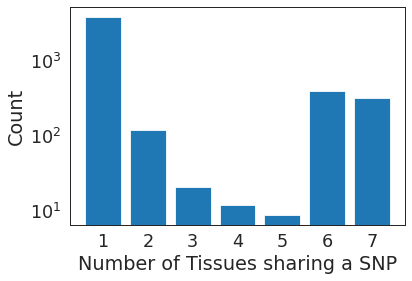

In [206]:
tissuecounts = dict(Counter(patient_snp_tissuecount.values()))
plt.bar(tissuecounts.keys(), tissuecounts.values())
plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("Number of Tissues sharing a SNP")
plt.xticks([1, 2, 3, 4, 5, 6, 7])
plt.show()

## What fraction of cardiac mosaicisms are shared in other tissue?

In [127]:
uniqueSNPs_germline_noblood = patient_tissue_uniqueSNP_df_filtered_germline[patient_tissue_uniqueSNP_df_filtered_germline['tissue']!='Blood']

In [128]:
pt_shared_snp_tissues_list = list()
for patientID, patientdf in patient_tissue_uniqueSNP_df_filtered_germline.groupby('patientID'):
    snps = patientdf['SNP'].unique()
    for snp in snps:
        snpdf = patientdf[patientdf['SNP']==snp]
        if len(snpdf['tissue'].unique()) > 2:
            for i in snpdf['tissue'].unique():
                for j in snpdf['tissue'].unique():
                    if i != j:
                        pt_shared_snp_tissues_list.append([patientID, snp, i, j])
pt_shared_snps_list_df = pd.DataFrame(pt_shared_snp_tissues_list)
pt_shared_snps_list_df.columns = ['patientID', 'SNP', 'tissue1', 'tissue2']
len(pt_shared_snps_list_df['SNP'].unique())/len(uniqueSNPs_germline_noblood)

0.03773584905660377

In [129]:
pt_shared_snps_list_df = map_columns(pt_shared_snps_list_df, 'refGene', 'SNP', SNP_refGene_dict)
pt_shared_snps_list_df['refGene'].unique()
# pt_shared_snps_list_df['patientID'].unique()

array(['TTN', 'COLGALT2'], dtype=object)

In [130]:
pt_shared_snps_list_df.groupby(['tissue1', 'tissue2']).size().to_frame(name = 'size').reset_index()

,tissue1,tissue2,size
0,Aorta,Blood,1
1,Aorta,CA,1
2,Aorta,LA,1
3,Aorta,LV,1
4,Aorta,RV,1
5,Blood,Aorta,1
6,Blood,CA,1
7,Blood,LA,2
8,Blood,LV,2
9,Blood,PA,1


In [131]:
pt_shared_snps_list_df[((pt_shared_snps_list_df['tissue1']=='Aorta') & (pt_shared_snps_list_df['tissue2']=='Blood'))
                      | ((pt_shared_snps_list_df['tissue1']=='Blood') & (pt_shared_snps_list_df['tissue2']=='Aorta'))]

,patientID,SNP,tissue1,tissue2,refGene
0,19,chr2:178661846:A>G,Aorta,Blood,TTN
5,19,chr2:178661846:A>G,Blood,Aorta,TTN


## Plotting top genes for all, HCM, ICM, and NICM

### VAF

In [132]:
genes_by_tissue_tot = dict()
genes_by_tissue_hcm = dict()
genes_by_tissue_nicm = dict()
genes_by_tissue_icm = dict()

for tissue, tissuedf in patient_tissue_uniqueSNP_df_filtered_germline.groupby('tissue'):
    genes_by_tissue_tot[tissue] = tissuedf.value_counts('refGene')
    genes_by_tissue_hcm[tissue] = tissuedf[tissuedf['CM_Type']=='HCM'].value_counts('refGene')
    genes_by_tissue_nicm[tissue] = tissuedf[tissuedf['CM_Type']=='NICM'].value_counts('refGene')
    genes_by_tissue_icm[tissue] = tissuedf[tissuedf['CM_Type']=='ICM'].value_counts('refGene')

In [133]:
def plotGenes(series, ylab, title, n):
    if len(series.head(n)) > 0:
        series.head(n).plot(kind='barh')
        plt.xlabel('Counts')
        plt.ylabel(ylab)
        plt.title(title)
        plt.show()

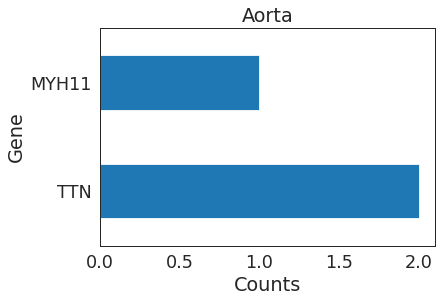

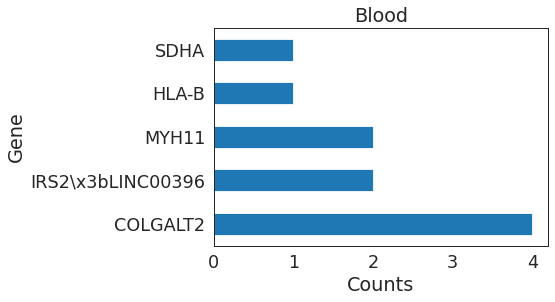

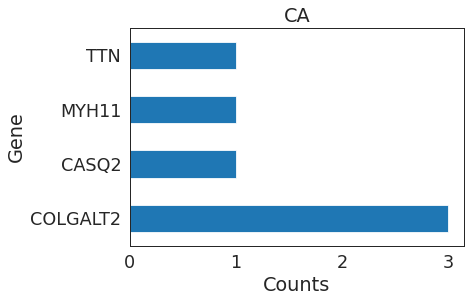

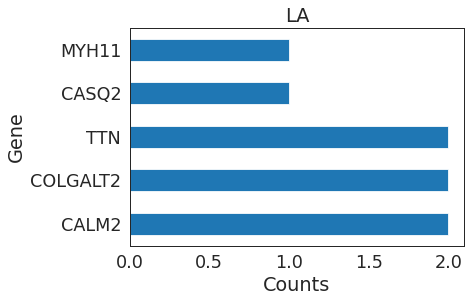

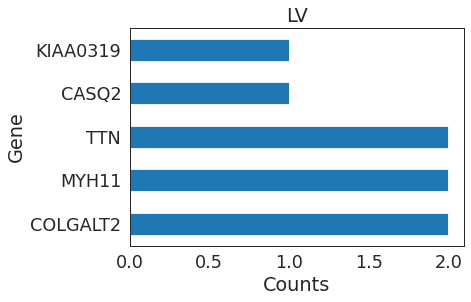

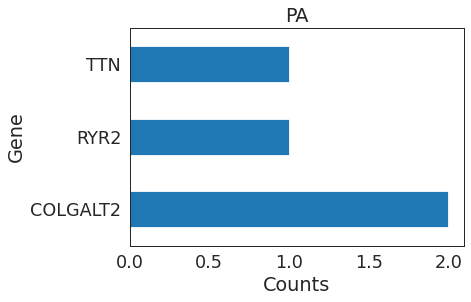

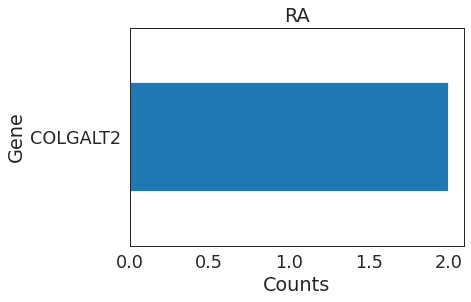

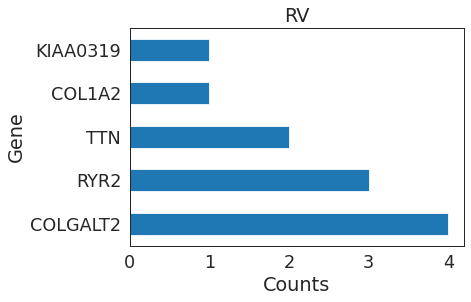

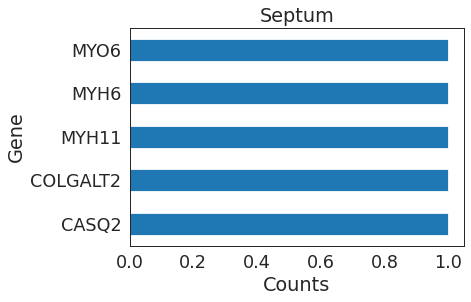

In [134]:
for tissue, value in genes_by_tissue_tot.items():
    plotGenes(value, "Gene", tissue, 5)

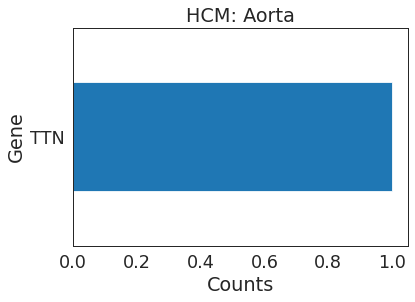

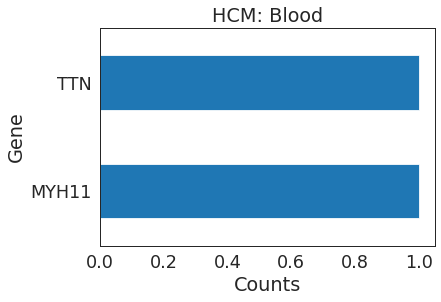

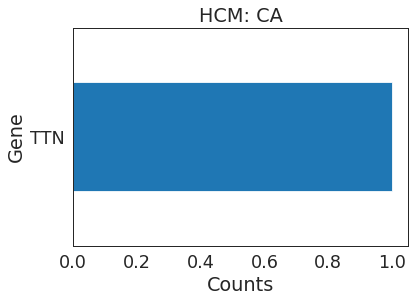

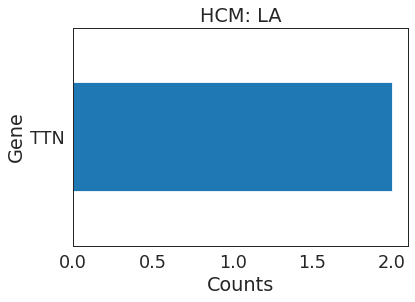

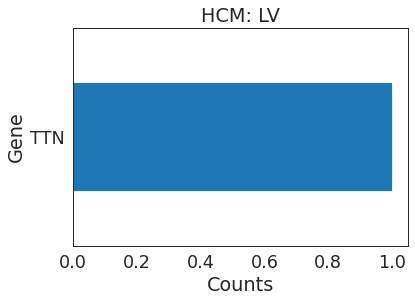

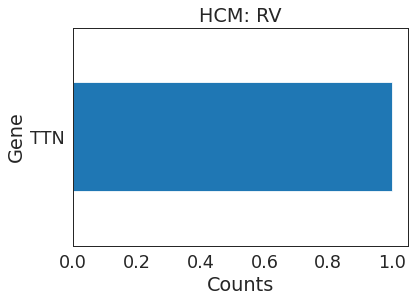

In [135]:
for tissue, value in genes_by_tissue_hcm.items():
    plotGenes(value, "Gene", "HCM: " + tissue, 5)

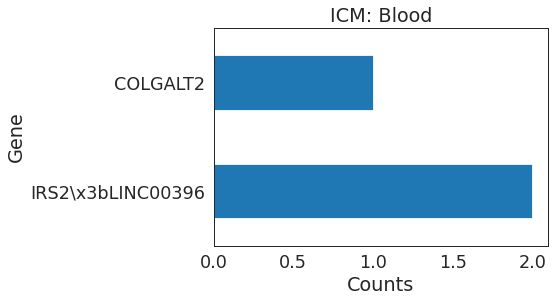

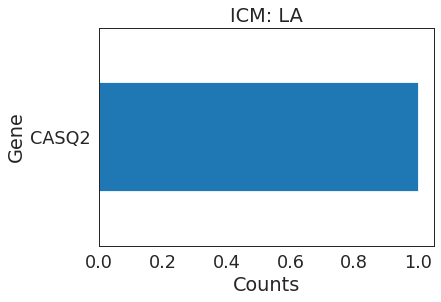

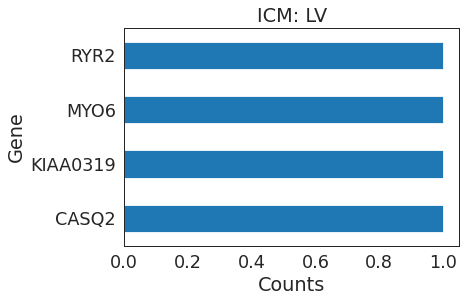

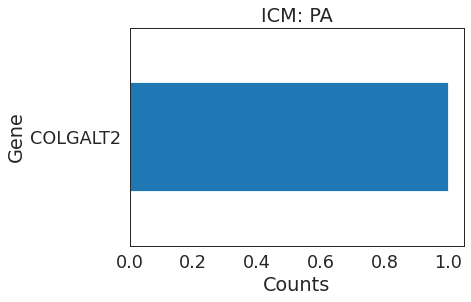

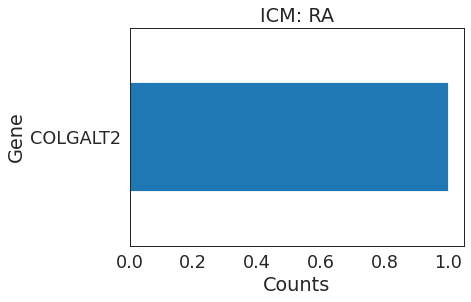

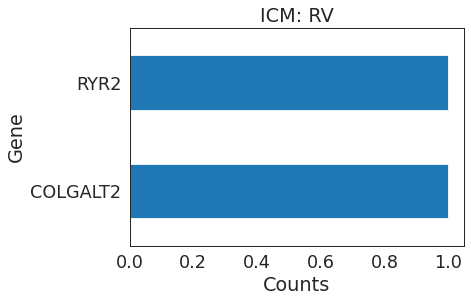

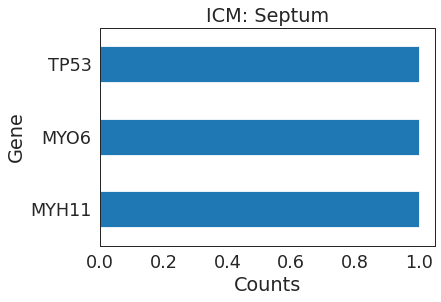

In [136]:
for tissue, value in genes_by_tissue_icm.items():
    plotGenes(value, "Gene", "ICM: " + tissue, 5)

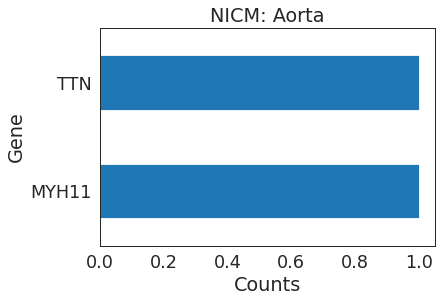

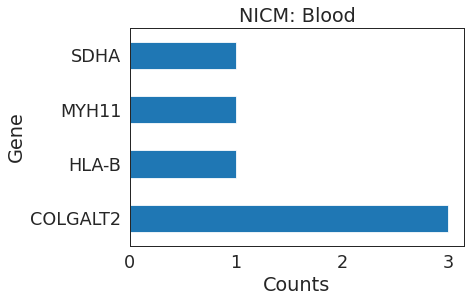

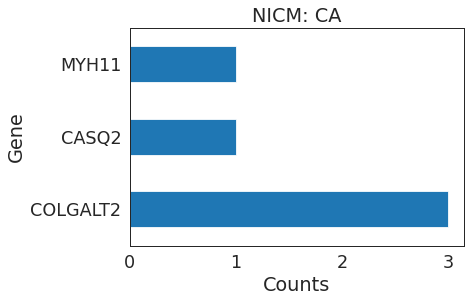

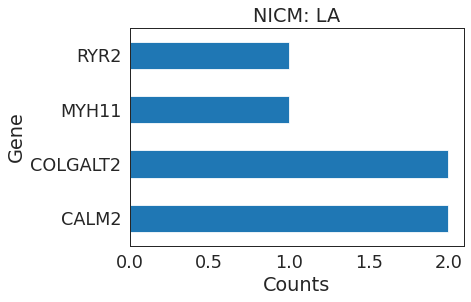

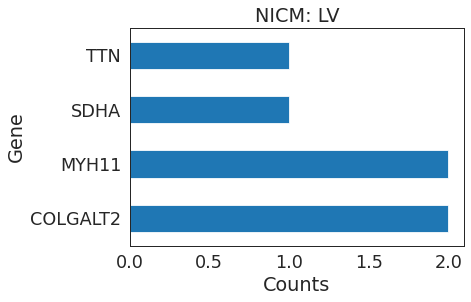

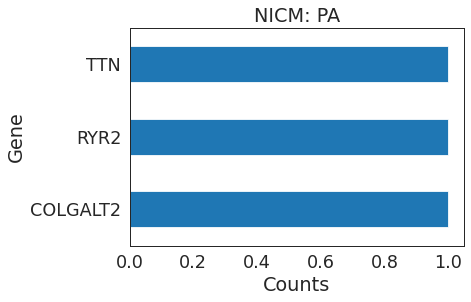

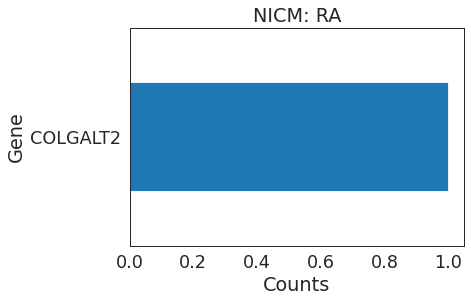

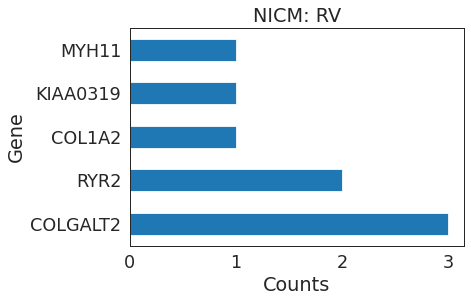

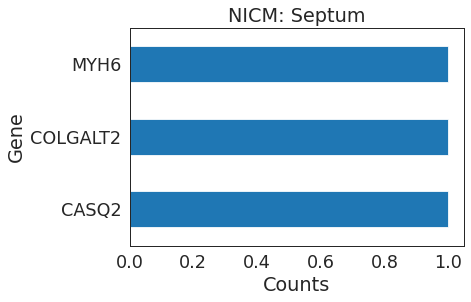

In [137]:
for tissue, value in genes_by_tissue_nicm.items():
    plotGenes(value, "Gene", "NICM: " + tissue, 5)

### Not VAF

In [170]:
genes_by_tissue_tot = dict()
genes_by_tissue_hcm = dict()
genes_by_tissue_nicm = dict()
genes_by_tissue_icm = dict()

for tissue, tissuedf in patient_tissue_uniqueSNP_df_novaf.groupby('tissue'):
    genes_by_tissue_tot[tissue] = tissuedf.value_counts('refGene')
    genes_by_tissue_hcm[tissue] = tissuedf[tissuedf['CM_Type']=='HCM'].value_counts('refGene')
    genes_by_tissue_nicm[tissue] = tissuedf[tissuedf['CM_Type']=='NICM'].value_counts('refGene')
    genes_by_tissue_icm[tissue] = tissuedf[tissuedf['CM_Type']=='ICM'].value_counts('refGene')

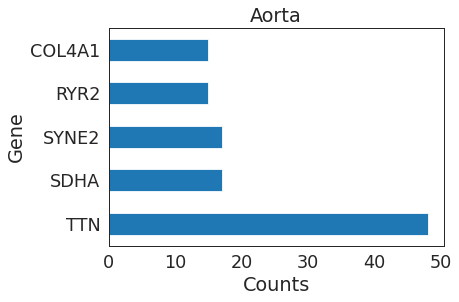

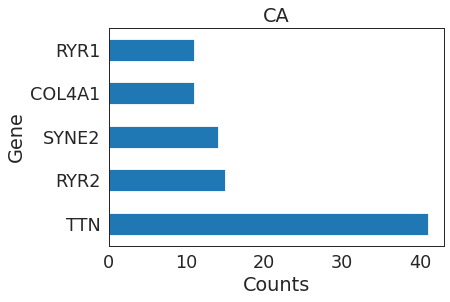

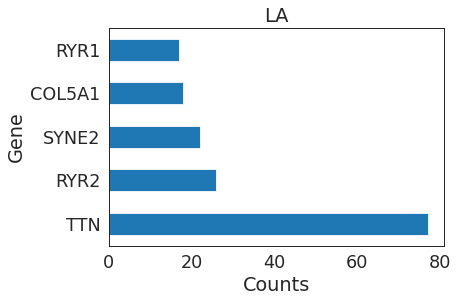

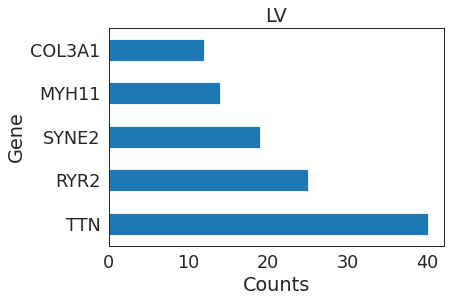

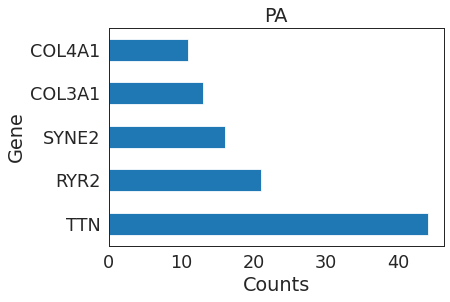

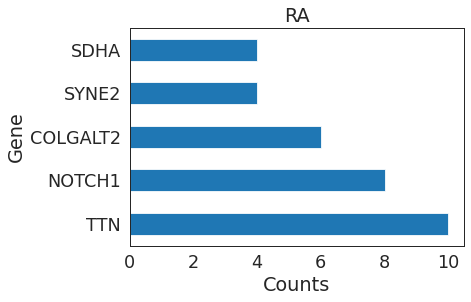

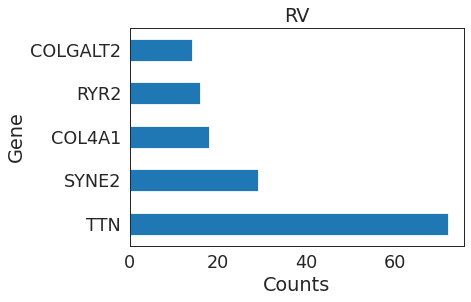

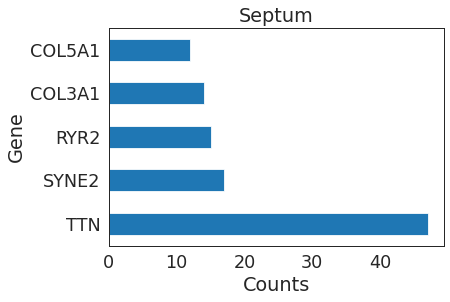

In [171]:
for tissue, value in genes_by_tissue_tot.items():
    plotGenes(value, "Gene", tissue, 5)

## Clustering tissue samples by jaccard similarity of sets of genes where they have a somatic SNP

In [223]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=40);
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=40);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

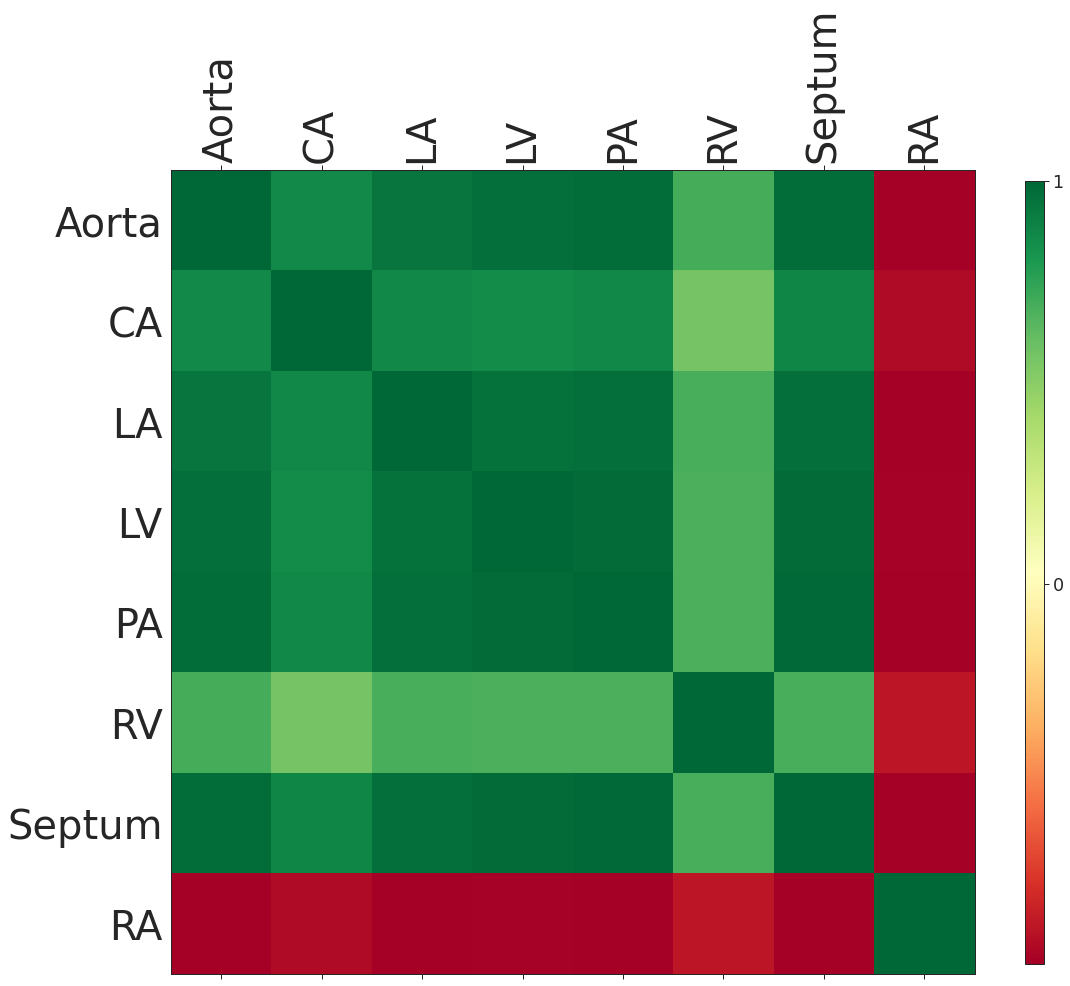

In [224]:
genes_by_tissue = dict()
for tissue, genelist in genes_by_tissue_tot.items():
    genes_by_tissue[tissue] = set(genelist.index)
jacc_sim_by_tissue = []
for x in genes_by_tissue.keys():
    for y in genes_by_tissue.keys():
        jaccard_similarity = len(genes_by_tissue[x].intersection(genes_by_tissue[y]))/len(genes_by_tissue[x].union(genes_by_tissue[y]))
        jacc_sim_by_tissue.append([x,y,jaccard_similarity])
jacc_sim_by_tissue_df = pd.DataFrame(jacc_sim_by_tissue)
jacc_sim_by_tissue_df = jacc_sim_by_tissue_df.pivot_table(index=0, columns=1, values=2)

d = sch.distance.pdist(jacc_sim_by_tissue_df)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [jacc_sim_by_tissue_df.columns.tolist()[i] for i in list((np.argsort(ind)))]

jacc_sim_by_tissue_df = jacc_sim_by_tissue_df.reindex(columns, axis=1)
fig, ax = plt.subplots(1, 1, figsize = (3, 3), dpi=300)

plot_corr(jacc_sim_by_tissue_df, size=18)
ax.set_ylabel('')    
ax.set_xlabel('')

plt.show()

## GO enrichment by phenotype - scrapped because of the genes in the assay were too specific

In [225]:
# icm_genes = set()
# for key, value in genes_by_tissue_icm.items():
#     for gene in value.index:
#         icm_genes.add(gene)
# for gene in icm_genes:
#     if '\\' not in gene:
#         print(gene)

In [226]:
# nicm_genes = set()
# for key, value in genes_by_tissue_nicm.items():
#     for gene in value.index:
#         nicm_genes.add(gene)
# for gene in nicm_genes:
#     if '\\' not in gene:
#         print(gene)

## Among somatic mutations present in heart tissue and not blood in pts with cardiomyopathy, are there enriched genes by locations or phenotype?

In [227]:
def enrichment(dataframe, col1, col2):
    output = []
    for group1 in dataframe[col1].unique():
        group1_df = dataframe[dataframe[col1]==group1]
        for group2 in group1_df[col2].unique():
            a = len(group1_df[group1_df[col2]==group2])
            c = len(group1_df[group1_df[col2]!=group2])
            b = len(dataframe[(dataframe[col2]==group2) & (dataframe[col1]!=group1)])
            d = len(dataframe) - a - b - c
            table = np.array([[a+1, b+1], [c+1, d+1]])
            oddsr, p = fisher_exact(table, alternative='two-sided')
            output.append([group1, group2, oddsr, p])
    return pd.DataFrame(output, columns = ['group1', 'group2', 'OR', 'p'])

In [228]:
tissue_gene_enrichment_df = enrichment(patient_tissue_uniqueSNP_df_filtered_germline, 'tissue', 'refGene')
tissue_gene_enrichment_df[tissue_gene_enrichment_df['p']<0.05/9]

,group1,group2,OR,p


In [229]:
cmtype_gene_enrichment_df = enrichment(patient_tissue_uniqueSNP_df_filtered_germline, 'CM_Type', 'refGene')
cmtype_gene_enrichment_df[cmtype_gene_enrichment_df['p']<0.05/3]

,group1,group2,OR,p
0,HCM,TTN,42.4,0.000007


In [230]:
tissue_gene_enrichment_df_novaf = enrichment(patient_tissue_uniqueSNP_df_novaf, 'tissue', 'refGene')
tissue_gene_enrichment_df_novaf[tissue_gene_enrichment_df_novaf['p']<0.05/len(tissue_gene_enrichment_df_novaf)]

,group1,group2,OR,p
2334,RA,NOTCH1,13.710074,1.423792e-07


In [231]:
cmtype_gene_enrichment_df_novaf = enrichment(patient_tissue_uniqueSNP_df_novaf, 'CM_Type', 'refGene')
cmtype_gene_enrichment_df_novaf[cmtype_gene_enrichment_df_novaf['p']<0.05/len(cmtype_gene_enrichment_df_novaf)]

,group1,group2,OR,p
100,NICM,COLGALT2,3.764185,8.138344e-08
214,NICM,NONE\x3bHACE1,13.110577,1.584411e-05
356,ICM,COLGALT2,0.293519,5.691275e-07
637,ICM,NONE\x3bHACE1,0.084170,3.717859e-05


## Cross-reference with RNA-Mutect called somatic variants

In [153]:
! gsutil cp 'gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/CV tissue analysis/NIHMS1604960-supplement-Table_S3.xlsx' .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/CV tissue analysis/NIHMS1604960-supplement-Table_S3.xlsx...
/ [1 files][  1.0 MiB/  1.0 MiB]                                                
Operation completed over 1 objects/1.0 MiB.                                      


In [154]:
rna_mutect_df = pd.read_excel('NIHMS1604960-supplement-Table_S3.xlsx', sheet_name='Sheet1')

#### Confirming all are SNPs

In [155]:
rna_mutect_df[rna_mutect_df['Start Position'] == rna_mutect_df['End Position']]

,Hugo Symbol,Chromosome,Start Position,End Position,Variant Classification,Variant Type,Reference Allele,Alternate Allele,Sample Name,Matched Normal Sample Name,Transcript Strand,Protein Change,SwissProt entry Id,Reference Context,Allele Fraction,Alternate Count,Reference Count,Tissue
0,TBCD,17,80765525,80765525,Missense_Mutation,SNP,C,T,Sample-10,Individual-2,+,p.R377W,TBCD_HUMAN,CACGGTCGTGCGGTGGTCTGC,0.066667,5,70,AdiposeTissue
1,CCDC3,10,12940572,12940572,Silent,SNP,C,T,Sample-29,Individual-7,-,p.E219E,CCDC3_HUMAN,TCTTCACTCGCTCCCGGAGCT,0.043636,11,263,AdiposeTissue
2,ABL1,9,133760565,133760565,Missense_Mutation,SNP,C,G,Sample-61,Individual-14,+,p.T963S,ABL1_HUMAN,CTCCCGGCCACTCCAAAGCCA,0.039326,5,171,AdiposeTissue
3,TEAD1,11,12901289,12901289,Missense_Mutation,SNP,T,C,Sample-61,Individual-14,+,p.M26T,TEAD1_HUMAN,CTGCAGCACATGGCGGCCATG,0.074074,4,50,AdiposeTissue
4,SH2B3,12,111856119,111856119,Missense_Mutation,SNP,C,T,Sample-65,Individual-15,+,p.P57L,SH2B3_HUMAN,CAGCACGCGCCGCTGCGCGCC,0.571429,4,3,AdiposeTissue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8865,KRT14,17,39739598,39739598,Missense_Mutation,SNP,C,T,Sample-2423,Individual-442,-,p.R388H,K1C14_HUMAN,CATCTCGCAGCGGAGCTGGGC,0.192308,5,21,Vagina
8866,CCDC64,12,120436351,120436351,Silent,SNP,G,A,Sample-2437,Individual-447,+,p.L152L,BICR1_HUMAN,AACATGAATTGAGAAGACGAT,0.071895,11,142,Vagina
8867,LY6D,8,143867098,143867098,Missense_Mutation,SNP,T,C,Sample-2449,Individual-448,-,p.T20A,LY6D_HUMAN,CAGCGCAGGGTAAGGGCTGGC,0.034161,9,311,Vagina
8868,LAMC2,1,183212589,183212589,3'UTR,SNP,C,T,Sample-2468,Individual-455,+,NaN,LAMC2_HUMAN,TCTCAGGGCTCGGGAGCCATG,0.080645,8,114,Vagina


### Filter to only somatic mutations 2% < VAF < 35%

In [156]:
rna_mutect_df_somaticheart = rna_mutect_df[(rna_mutect_df['Tissue']=='Heart') & ((rna_mutect_df['Allele Fraction'] > 0.1) & (rna_mutect_df['Allele Fraction'] < 0.30))]

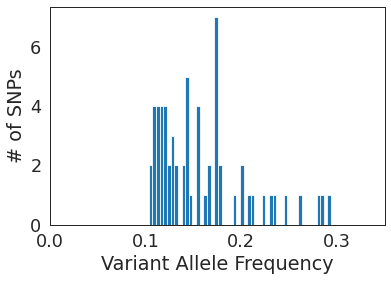

Min: 0.103448
Max: 0.294118
Median: 0.1433035


In [157]:
plot_histogram(rna_mutect_df_somaticheart, 'Allele Fraction', 'Variant Allele Frequency', '# of SNPs', 0, 0.35, 50)

### Standardize SNP format

In [158]:
rna_mutect_df_somaticheart['SNP'] = rna_mutect_df_somaticheart.apply(lambda row: 'chr' + 
                                 str(row['Chromosome']) + 
                                 ":" + str(row['Start Position']) + 
                                 ":" + row['Reference Allele'] + ">" 
                                 + row['Alternate Allele'], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Find intersection of sets of SNPs and genes between Yizhak et al and our samples

In [159]:
yizhak_snps = set(rna_mutect_df_somaticheart['SNP'])
yizhak_genes = set(rna_mutect_df_somaticheart['Hugo Symbol'])

In [165]:
uniqueSNPs_novaf.intersection(yizhak_snps)

set()

In [166]:
uniqueSNP_genes_novaf.intersection(yizhak_genes)

{'ADAMTS7', 'CREB5', 'TTN'}

In [168]:
jaccard_similarity = len(uniqueSNP_genes_novaf.intersection(yizhak_genes))/len(uniqueSNP_genes_novaf.union(yizhak_genes))
print(jaccard_similarity)

0.006147540983606557


In [163]:
len(yizhak_genes)

62

In [169]:
len(uniqueSNP_genes_novaf)

429

# Gold Standard

In [260]:
intersection_df = patient_tissue_uniqueSNP_df_novaf[patient_tissue_uniqueSNP_df_novaf['SNP'].isin(uniqueSNPs_novaf.intersection(uniqueSNPs_vaf))]

In [261]:
intersection_df

,patientID,tissue,SNP,refGene,exonicFunc,LVEF,CM_Type,AF,tissuetype
119,19,LA,chr2:178698916:TAA>T,TTN,.,50-60,HCM,0.178,LA
323,123,Aorta,chr1:183938212:A>ATTTTT,COLGALT2,.,25,NICM,0.077,Aorta
324,123,RV,chr1:183938212:A>ATTTTT,COLGALT2,.,25,NICM,0.077,RV
751,155,LV,chr16:15798624:C>A,MYH11,.,20-Oct,NICM,0.237,LV
752,155,Septum,chr16:15798624:C>A,MYH11,.,20-Oct,NICM,0.237,Septum
...,...,...,...,...,...,...,...,...,...
8727,1008,Septum,chr16:15798624:C>A,MYH11,.,20-30,ICM,0.237,Septum
8769,1008,LV,chr1:237742270:CT>C,RYR2,.,20-30,ICM,0.346,LV
8770,1008,RV,chr1:237742270:CT>C,RYR2,.,20-30,ICM,0.346,RV
8839,1008,LV,chr6:24590296:CAA>CA,KIAA0319,.,20-30,ICM,0.167,LV


In [266]:
tissue_gene_enrichment_df = enrichment(intersection_df, 'tissue', 'refGene')
tissue_gene_enrichment_df[(tissue_gene_enrichment_df['p']<0.05) & (tissue_gene_enrichment_df['OR']>1.0)]

,group1,group2,OR,p
18,RV,RYR2,3.973214,0.039232
35,LV,KIAA0319,7.342105,0.045344
53,PA,CALM2,6.400000,0.045946
54,RA,COLGALT2,6.370968,0.027978
61,CA,CASQ2,6.750000,0.036238


In [265]:
cm_gene_enrichment_df = enrichment(intersection_df, 'CM_Type', 'refGene')
cm_gene_enrichment_df[(cm_gene_enrichment_df['p']<0.05) & (cm_gene_enrichment_df['OR']>1)]

,group1,group2,OR,p
0,HCM,TTN,20.800000,0.027486
1,NICM,COLGALT2,3.305785,0.005101
16,ICM,TP53,9.280000,0.016504
18,ICM,HLA-B,9.280000,0.016504
